# TP n°1 : Introduction: Python, Numpy, Pandas, *et al*

In [1]:
# Standard Library
import datetime
import sys
import urllib
import zipfile

from datetime import datetime
from os import path

# Other Libraries
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.dates as mdates
import matplotlib.pyplot as plt  # for plots
from matplotlib import rc

# 2 - Introduction à Pandas, Matplotlib, etc

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/'
filename ='household_power_consumption'
zipfilename = filename + '.zip'
Location = url + zipfilename

# testing existence of file:
if sys.version_info >= (3, 0):
    if not(path.isfile('zipfilename')):
        urllib.request.urlretrieve(Location, zipfilename)
    else:
        if not(path.isfile('zipfilename')):
            urllib.urlretrieve(Location, zipfilename)
            
# unzip part
zip =  zipfile.ZipFile(zipfilename)
zip.extractall()

# Creating dataframe df
na_values = ['?', '']
fields = ['Date', 'Time', 'Global_active_power']
df = pd.read_csv(filename + '.txt', sep=';', nrows=200000,
na_values = na_values, usecols=fields)

In [3]:
# Head of the table
df.head()

,Date,Time,Global_active_power
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


### 1) Détecter et dénombrer le nombre de lignes ayant des valeurs manquantes.

In [4]:
# Projecting on the column 'Global_active_power' and attributes a value  
# 'True' to the missing values and false to the effective values
null_list = df['Global_active_power'].isnull()

# Count the occurence of 'True' and 'False'
count_null = null_list.value_counts()
print('Nombre de lignes ayant des valeurs : ' + str(count_null[0]))
print('Nombre de lignes ayant des valeurs manquantes : ' + str(count_null[1]))

Nombre de lignes ayant des valeurs : 196268
Nombre de lignes ayant des valeurs manquantes : 3732


### 2) Supprimer toutes les lignes avec des valeurs manquantes.

In [5]:
# Cleaning table df (removing missing values)
df = df.dropna(axis=0)
df.shape

(196268, 3)

### 3) Utiliser to_datetime et set_index  pour créer une Time Series (on prendra garde au format des dates internationales qui diffère du format français).

In [6]:
# Converting date in a time series with method to_datetime
date = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

In [7]:
# Indexing by date with method set_index
s = df.set_index(date)['Global_active_power']
s.head()

2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float64

### 4) Afficher le graphique des moyennes journalières entre le 1er janvier et le 30 avril 2007. Proposer une cause expliquant la consommation fin février et début avril. On pourra utiliser en plus de matplotlib le package seaborn pour améliorer le rendu visuel.

In [8]:
# TimeSeries by day mean values on Global_active_power
s_day = s['2007-01-01': '2007-04-30'].resample("D").mean()
s_day.head()

2007-01-01    1.909031
2007-01-02    0.881414
2007-01-03    0.704204
2007-01-04    2.263481
2007-01-05    1.884281
Freq: D, Name: Global_active_power, dtype: float64

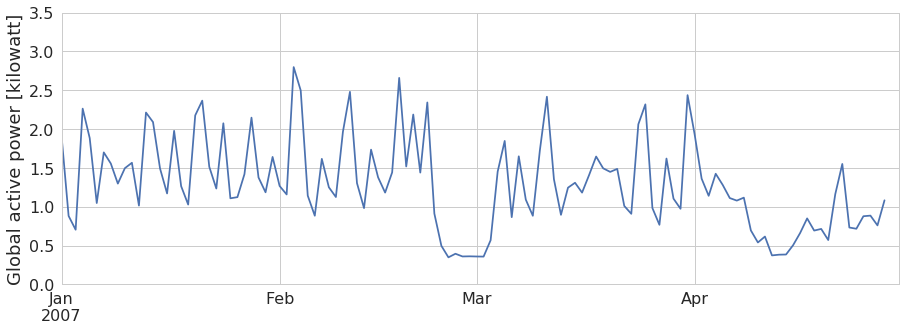

In [9]:
% matplotlib inline
sns.set(style="whitegrid")
# Creating the curve of the global active power by day
ax = s_day.plot(figsize=(15, 5), ylim=(0, 3.5) , legend=False, fontsize=16);
ax.set_ylabel('Global active power [kilowatt]', fontsize=18)
ax.set_xlabel('')

### Proposition d'explication:
- Nous suivons la consommation d'énergie d'un foyer. La chute brusque à la fin du mois de février et la reprise tout aussi brusque, semblent indiquer que le logement est vacant durant cette période qui dure 1 semaine. Sous l'hypothèse que le foyer comprant des enfants et qu'il est situé en France (la source des dates est française), on peut supposer qu'il s'agit des vacances scolaires. On peut donc resteindre la zone géographique : seules les zones B et C avaient des congés scolairesfin février-début mars (http://cache.media.education.gouv.fr/file/83/6/5836.pdf).
- En ce qui concerne la baisse de la consommation début avril, elle est bien plus progressive et est cohérente avec une baisse de la consommation énergétique de chauffage au début du printemps (le chauffage du logement est en effet électrique: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption).

### Afin de vérifier nos hypothèses, étudions les courbes de consommation électrique de la cuisine et de la climatisation réversible:

In [10]:
# new Dataframe df_tot with the global consumption of energy 
# 'Global_active_power', kitchen consumption 'Sub_metering_3'  
# and the reversible heater 'Sub_metering_3'
filename ='household_power_consumption'

fields = ['Date', 'Time', 'Global_active_power', 'Sub_metering_1', 
          'Sub_metering_3']
df_tot = pd.read_csv(filename + '.txt', sep=';', nrows=200000,
                        na_values=na_values, names=fields, 
                        usecols=[0, 1, 2, 6, 8], low_memory=False, 
                        header=0)
date =  pd.to_datetime(df_tot['Date'] + ' ' + df_tot['Time'], dayfirst=True)
df_tot.set_index(date, inplace=True)
df_tot_day = df_tot.resample("D").mean() 
df_tot_day = df_tot_day.rename(columns = {"Sub_metering_1": "cuisine", 
                                                "Sub_metering_3": "chauffage"})
df_tot_day.head()

,Global_active_power,cuisine,chauffage
2006-12-16,3.053475,0.000000,12.439394
2006-12-17,2.354486,1.411806,9.264583
2006-12-18,1.530435,0.738194,9.734722
2006-12-19,1.157079,0.582639,4.303472
2006-12-20,1.545658,0.000000,9.765972


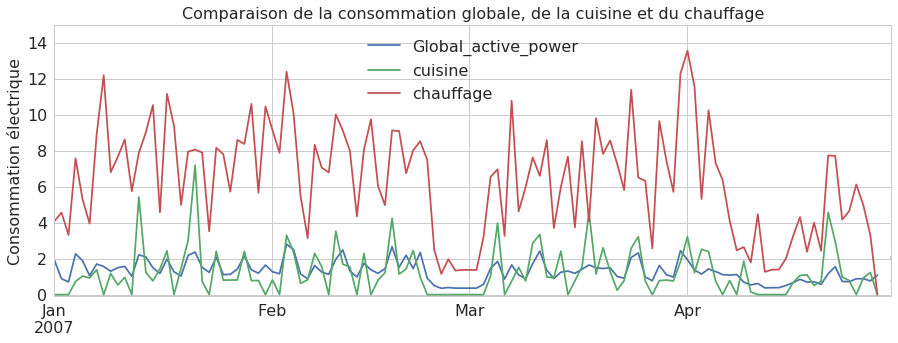

In [11]:
# Curve of energy consumption (global and reversible heater)
dstart = datetime(2007, 1, 1)
dstop  = datetime(2007, 4, 30)
ax = df_tot_day.plot(figsize=(15, 5), ylim=(-0.1, 15), fontsize=16, 
                        xlim=(dstart, dstop))
ax.set_ylabel("Consommation électrique", fontsize=16)
ax.set_title("Comparaison de la consommation globale, de la cuisine et du"
             " chauffage", fontsize=16)
ax.legend(fontsize=16)
ax.set_xlabel('')

Les consommation électriques de la cuisine (en vert) et du chauffage (en rouge) s'effondrent brutalement fin février, ce qui est cohérent avec une absence de domicile. Fin avril, la consommation de chauffage baisse progressivement tandis que la consommation de la cuisine continue à atteindre des niveaux de pics comparable au reste de l'année. La baisse globale est donc bien due à une baisse du chauffage, cohérente avec l'arrivée du printemps. Notons, que l'ensemble des consommations atteint de nouveau un plateau minimal durant une semaine milieu avril ce qui correspond sûrement à une nouvelle absence de domicile 

### 5) Charger les données avec pandas , et ne garder que les colonnes DATE et TG . Diviser par 10 la colonne TG p our obtenir des températures en degrés Celsius. Traiter les éléments de température ab errants comme des NaN.

In [12]:
file = 'TGSTAID011249.txt'
na_values = ['?', '']
fields = ['DATE', 'TG']

# Importing Orly temperature reading in a dataframe df2 with a
# DatetimeIndex (equivalent to apply to_datetime then set_index)
df2 = pd.read_csv(file, sep=',', low_memory=False, na_values=na_values, 
                  comment='#', usecols=[2, 3], names=fields, header=0, 
                  parse_dates=[0], index_col=0, dtype={'TG': np.float64})

# Changing temperature in Celsius degrees
df2['TG'] = df2['TG']/10.0
df2 = df2.dropna()

# Dataframe head
df2.head()

,TG
DATE,
1921-03-01,5.0
1921-03-02,4.6
1921-03-03,4.6
1921-03-04,3.1
1921-03-05,9.5


### 6) Créer une Time Series pandas des températures journalières entre le 1er janvier et le 30 avril 2007. Afficher sur un même graphique ces températures et la Time Series Global_active_power .


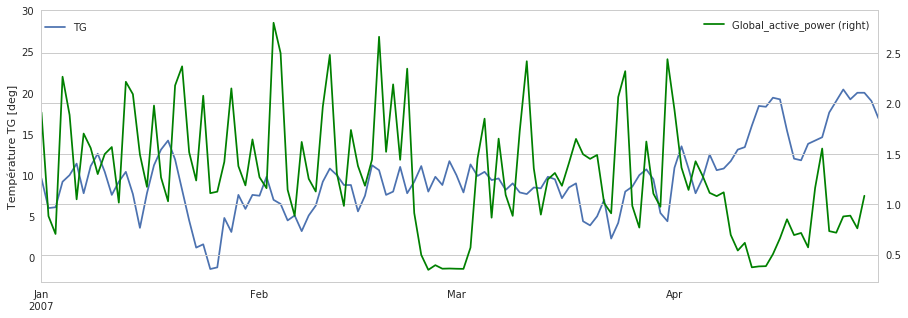

In [13]:
# Creating a time Series averaged by day
s2_day = df2.set_index(df2.index)['TG']['2007-01-01':'2007-04-30']

# Curves of global active power and temperatures evolutions by day 
# between January and May 2007

## Curve of Temperatures
ax = s2_day.plot(figsize=(15, 5), ylim=(-3, 30))
ax.set_ylabel("Température TG [deg]")
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(0., 0.87, 1., .102), loc=2,
           ncol=2, mode="expand", borderaxespad=0.)
ax.grid()

## Curve of Global active power
ax2 = ax.twinx()
ax2.set_ylabel("Global active Power [kilowatt]")
s_day.plot(ax = ax2, ylim=(0.0, 3.5), secondary_y=True, style='g-', legend=True)

### 7) Proposer une visualisation de la pollution moyenne par année (pour l'ozone).

In [14]:
zipfilename = 'airparifabae1bd78def4fe8a409ab8c95fc4608.zip'
filename = '20080421_20160927-PA13_auto.csv'

# unzip part
zip =  zipfile.ZipFile(zipfilename)
zip.extractall()

na_values = ['?', '', ' ', 'n/d']
names=['date', 'heure', 'NO2', 'O3']

# Creates dataframe df3 with date+time in index
df3 = pd.read_csv(filename, sep=';', header=1, parse_dates=[[0, 1]], 
                  index_col=0, names=names, na_values=na_values,
                  dtype={'NO2': float, 'O3': float})

# Replace all hours equal to 24 by 0
df3.index = df3.index.str.replace(' 24',' 00')

# Create a time series on the index
df3.index = pd.to_datetime(df3.index, format='%d/%m/%Y %H', errors='coerce')

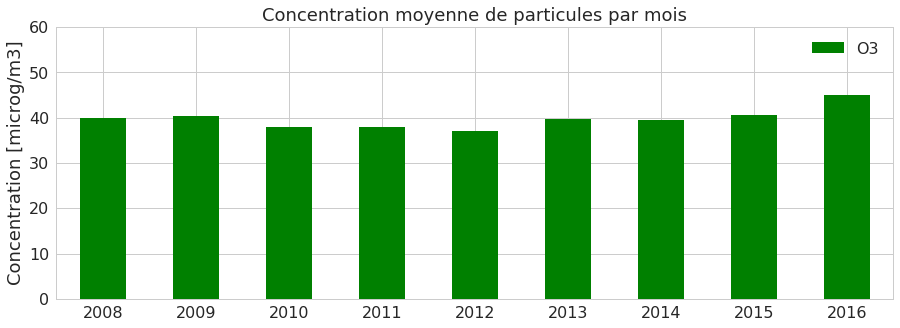

In [15]:
# df3_year : averaged pollution by year 
df3_year = df3.groupby(df3.index.year).mean()['O3']

# Plot of the particule concentration averaged by year
ax = df3_year.plot(figsize=(15, 5), kind='bar', fontsize=16, ylim=(0, 60), 
                       rot=0, color='g');
ax.set_ylabel("Concentration [microg/m3]", fontsize=18)
ax.set_xlabel("")
ax.set_title("Concentration moyenne de particules par mois", fontsize=18)
ax.legend(fontsize=16)

### 8) Proposer une visualisation de la pollution la plus critique par année pour l'ozone et pour le dioxyde d'azote.


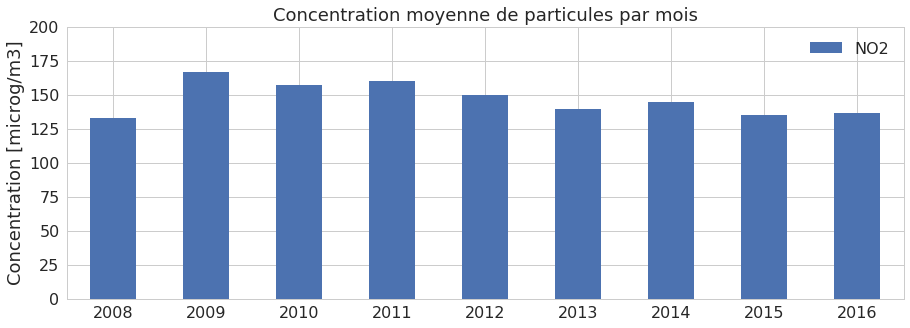

In [16]:
# df3_max : maximum peak of pollution by year 
df3_max = df3.groupby(df3.index.year).max()['NO2']

# Plot of the critical particule concentration by year
ax = df3_max.plot(figsize=(15, 5), kind='bar', fontsize=16, ylim=(0, 200), 
                       rot=0);
ax.set_ylabel("Concentration [microg/m3]", fontsize=18)
ax.set_xlabel("")
ax.set_title("Concentration moyenne de particules par mois", fontsize=18)
ax.legend(fontsize=16)

### 9) Donner une représentation par mois de la pollution. Quel est le mois le plus pollué?

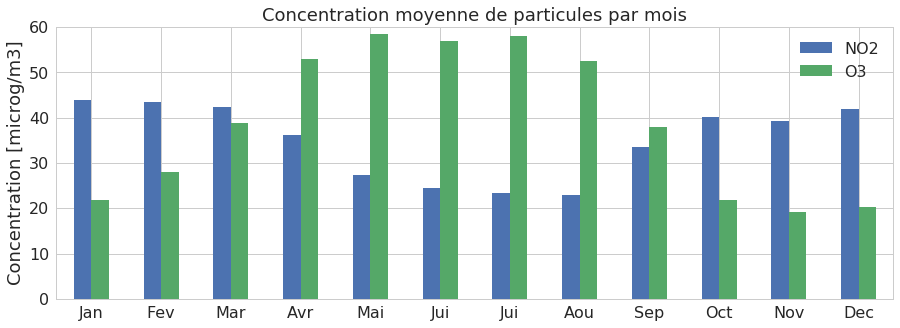

In [17]:
# Particule concentration averaged by month
df3_month = df3.groupby(df3.index.month).mean()

# Plot of the particule concentration by month
ax = df3_month.plot(figsize=(15, 5), kind='bar', fontsize=16, ylim=(0, 60), 
                       rot=0);
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Jui', 'Jui', 'Aou',
                    'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel("Concentration [microg/m3]", fontsize=18)
ax.set_xlabel("")
ax.set_title("Concentration moyenne de particules par mois", fontsize=18)
ax.legend(fontsize=16)


In [18]:
name_months = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin',
               'juillet', 'aout', 'sep', 'oct', 'nov', 'dec']
peaks = df3_month.idxmax(axis=0)

for i in range(2):
    print(('La concentration de %s est maximale au mois de %s.') 
          %(peaks.index[i], name_months[df3_month.idxmax(axis=0)[i]-1]))

La concentration de NO2 est maximale au mois de janvier.
La concentration de O3 est maximale au mois de mai.
